In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep


2024-10-09 16:16:48.082283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 16:16:48.088516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 16:16:48.805819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 16:16:50.465165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 16:17:05.311670: W tensorflow/compiler/tf2

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

## Download Data

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))
train_data[LABEL].mean(), test_data[LABEL].mean()

(0.2408095574460244, 0.23621176759611842)

In [7]:
test_data = test_data.iloc[1:, :] # drop invalid row

In [8]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [9]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [10]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

## Modelling Prep

In [11]:
def df_to_dataset(
    dataframe: pd.DataFrame,
    target: str = None,
    shuffle: bool = True,
    batch_size: int = 512,
):
    df = dataframe.copy()
    if target:
        labels = df.pop(target)
        dataset = {}
        for key, value in df.items():
            dataset[key] = value.to_numpy()[:, tf.newaxis]

        dataset = tf.data.Dataset.from_tensor_slices((dict(dataset), labels))
    else:
        dataset = {}
        for key, value in df.items():
            dataset[key] = value.to_numpy()[:, tf.newaxis]

        dataset = tf.data.Dataset.from_tensor_slices(dict(dataset))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(batch_size)
    return dataset

In [12]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

2024-10-09 16:17:45.765259: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-09 16:17:49.014001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-09 16:17:49.015674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-09 16:17:49.024604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-09 16:17:49.025039: I external/local_xla/xla/stream_executor

# FTTransformer

## FT Transformer - Linear Numerical Encoding

In [13]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=16,
    depth=4,
    heads=8,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=True
)

# Pass the encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation='sigmoid',
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000


2024-10-09 16:17:59.668363: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-09 16:18:04.471452: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


51/51 [==============================] - 53s 526ms/step - loss: 0.4013 - output_loss: 0.4013 - output_PR AUC: 0.6232 - val_loss: 0.3281 - val_output_loss: 0.3281 - val_output_PR AUC: 0.7615
Epoch 2/1000
51/51 [==============================] - 102s 2s/step - loss: 0.3402 - output_loss: 0.3402 - output_PR AUC: 0.7231 - val_loss: 0.3194 - val_output_loss: 0.3194 - val_output_PR AUC: 0.7661
Epoch 3/1000
51/51 [==============================] - 19s 371ms/step - loss: 0.3337 - output_loss: 0.3337 - output_PR AUC: 0.7322 - val_loss: 0.3202 - val_output_loss: 0.3202 - val_output_PR AUC: 0.7634
Epoch 4/1000
51/51 [==============================] - 143s 3s/step - loss: 0.3275 - output_loss: 0.3275 - output_PR AUC: 0.7434 - val_loss: 0.3250 - val_output_loss: 0.3250 - val_output_PR AUC: 0.7601
Epoch 5/1000
51/51 [==============================] - 67s 1s/step - loss: 0.3255 - output_loss: 0.3255 - output_PR AUC: 0.7468 - val_loss: 0.3165 - val_output_loss: 0.3165 - val_output_PR AUC: 0.7705
Epoch

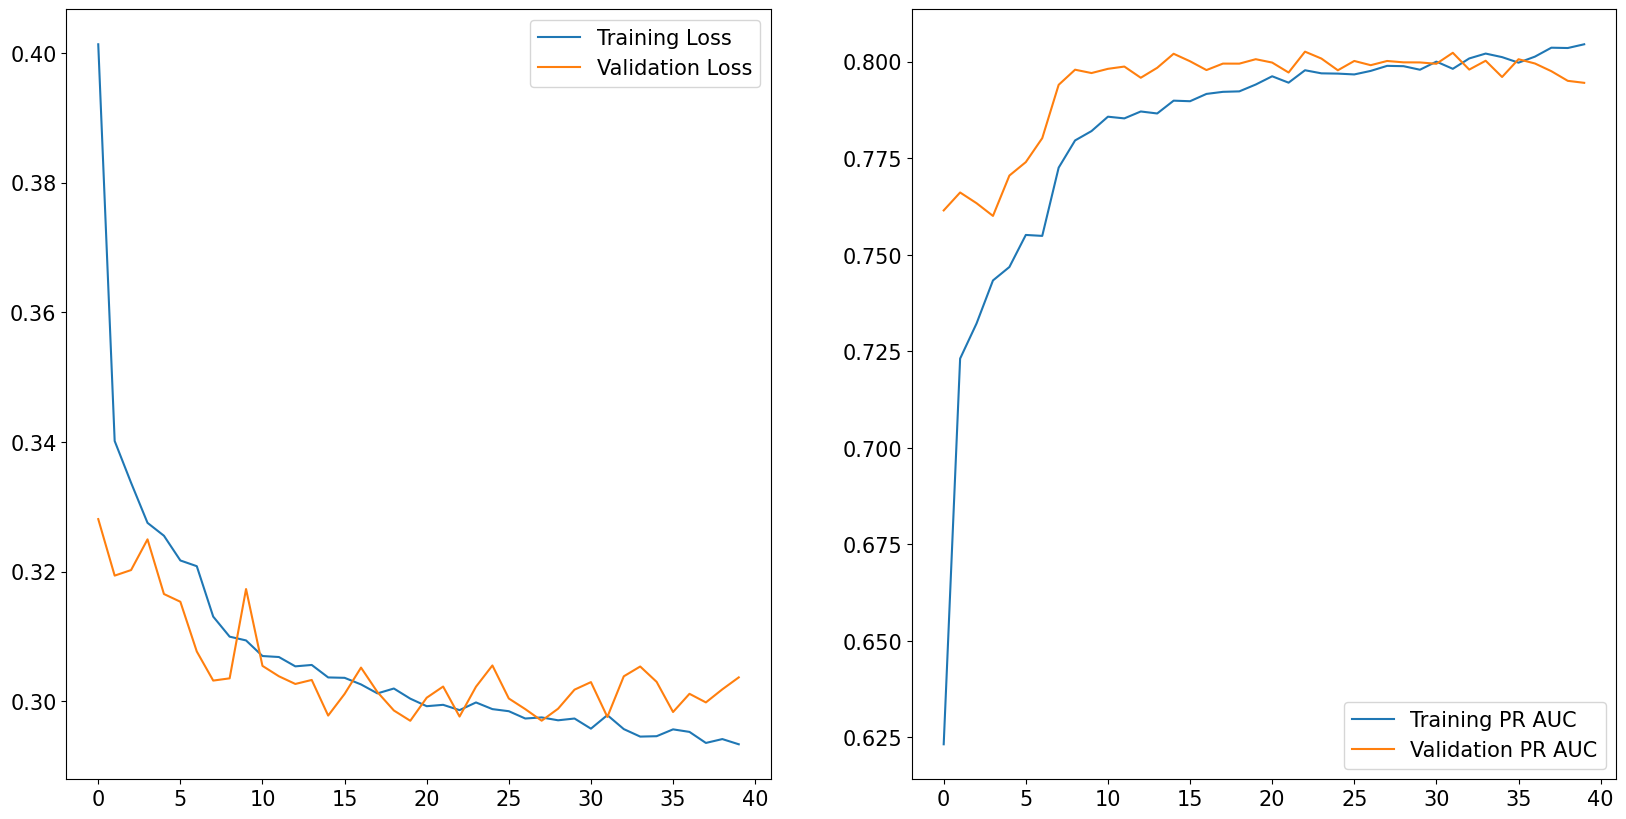

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
ax[1].legend()

plt.show()

In [15]:
linear_test_preds = ft_linear_transformer.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], linear_test_preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

32/32 [==============================] - 2s 30ms/step
FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.9105
Test PR AUC: 0.7792
Test Accuracy: 0.8561


## Explainability

In [16]:
import matplotlib.pyplot as plt

def get_model_importances(importances_df, title):
    """
    Plot feature importances and return the average value of each feature.

    Args:
        importances_df (pd.DataFrame): DataFrame containing feature importances.
        title (str): Title for the plot.

    Returns:
        pd.Series: Average value of each feature, sorted in descending order.
    """
    # Calculate the average value of each column
    average_importances = importances_df.mean()

    # Sort the average values in descending order
    sorted_importances = average_importances.sort_values(ascending=False)

    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    ax = sorted_importances.plot(kind='bar')
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')

    # Annotate each bar with the value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.show()
    
    return sorted_importances

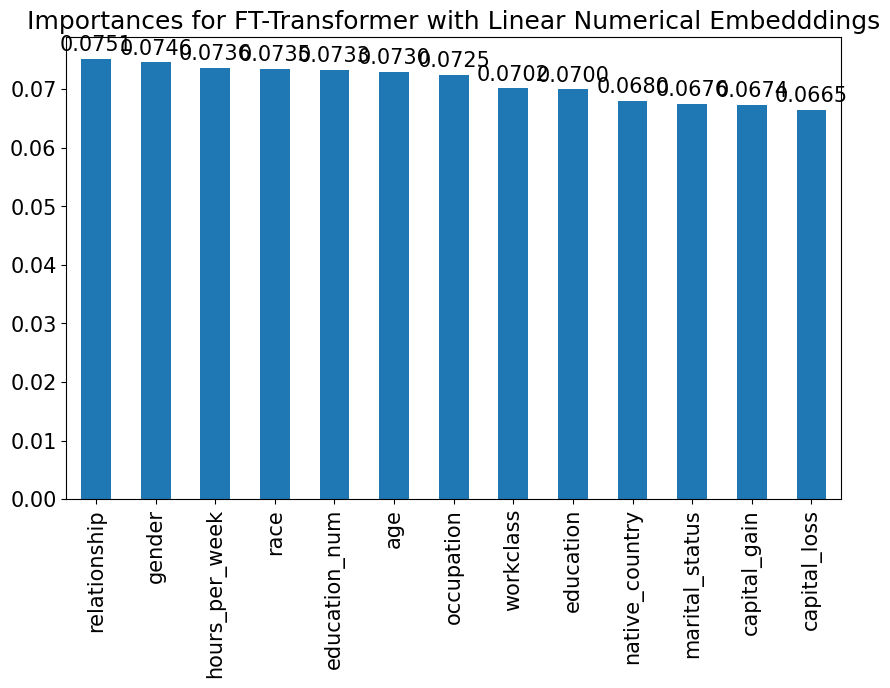

In [17]:
linear_importances = linear_test_preds['importances']
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [18]:
print(linear_total_importances)

relationship      0.075147
gender            0.074591
hours_per_week    0.073613
race              0.073466
education_num     0.073347
age               0.073029
occupation        0.072487
workclass         0.070181
education         0.070001
native_country    0.068035
marital_status    0.067571
capital_gain      0.067393
capital_loss      0.066535
dtype: float32


In [19]:
# Largest prediction
max_idx = np.argsort(linear_test_preds['output'].ravel())[-1]
example_importance_linear = linear_importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[max_idx, :].rename("Example Vlaue")
).head(5)
print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[max_idx], 4))}")
display(example_importance_linear)

# Smallest one
min_idx = np.argsort(linear_test_preds['output'].ravel())[0]
example_importance_linear = linear_importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[min_idx, :].rename("Example Vlaue")
).head(5)
print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[min_idx], 4))}")
display(example_importance_linear)

Top 5 contributions to row 6650 which was scored 0.9841


,Importance,Example Vlaue
gender,0.177096,Male
workclass,0.089128,Private
capital_gain,0.088867,1.763209
age,0.088088,0.250514
education,0.087510,Assoc-acdm


Top 5 contributions to row 14349 which was scored 0.0014


,Importance,Example Vlaue
hours_per_week,0.118763,-0.681673
capital_gain,0.089203,-0.145709
race,0.078489,White
occupation,0.073201,Farming-fishing
relationship,0.069505,Not-in-family
